# DarkELF Migdal notebook

This notebook is meant to illustrate the main features of the darkELF package for calculating scattering rates through the Migdal effect.

written by Tongyan Lin & Simon Knapen, 04/20/2021

In [1]:
%matplotlib inline

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# uses matplotlib-label-lines, see for example https://github.com/cphyc/matplotlib-label-lines
from labellines import labelLine, labelLines

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

Import the package. For each material we want to study, we will create a darkELF object. The user must also specify the file from which the dielectric function will be imported, which can be found in the data folder corresponding to the material of interest. The dark matter mass is also set at this stage. It can be updated with the update_param() function (see below), without having to create a new darkELF object.

describe optional flags

In [2]:
targets.list_all()

	 Al2O3
	 GaN
	 Al
	 ZnS
	 GaAs
	 SiO2
	 Si
	 Ge
	 SiC
	 C
	 Xe


In [3]:
targets.files('Si')

Available configuration files: 
	 Si.yaml
 
Available data for epsilon: 
	 Si_Migdal_FAC.dat
	 Si_mermin.dat
	 Si_gpaw_noLFE.dat
	 Si_gpaw_withLFE.dat
	 Si_epsphonon_theory6K.dat
	 Si_epsphonon_data6K.dat
	 Si_Zion.dat


The Si_Migdal_FAC.dat files refer to the atomic form factor from Ibe et. al. They are called for if the "method=Ibe" flag is used in the rate calculations. They are not available for all materials, and darkelf will produce a warning message if it could not find this file. This only means that "method=Ibe" option is not available for this material, all other functionalities should work normally. In the example below we moreover did not specified a filename for the response function in the phonon regime, which triggers a warning message. This only means that we cannot use the phonon functionalities here, which is fine since we are only concerned with the Migdal calculation here. For details on the phonon calculations see darkelf_phonon.ipynb. 

Load mermin and gpaw grids for Si and Ge

In [16]:
mX=5.0e8

# create an object for each target material. This reads in precalculated tables for the ELF and interpolates them
# also specify the dark matter mass
Si_gpaw = darkelf(target='Si',mX=mX,filename="Si_gpaw_withLFE.dat")
print("")
Si_mermin = darkelf(target='Si',mX=mX,filename="Si_mermin.dat")
print("")

Ge_gpaw = darkelf(target='Ge',mX=mX,filename="Ge_gpaw_withLFE.dat")
print("")
Ge_mermin = darkelf(target='Ge',mX=mX,filename="Ge_mermin.dat")
print("")


 .... Loading files for Si
Loaded Si_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000

 .... Loading files for Si
Loaded Si_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
Warning! 

Set a list of electronic excitation energies which we'll use throughout the notebook to make plots. 

In [5]:
omlist=np.linspace(1.0,30.0,50) # list of electronic excitation energies, used for plotting throughout this notebook

## Elastic nuclear recoil

In [6]:
?Si_gpaw.dRdEn_nuclear

Signature: Si_gpaw.dRdEn_nuclear(En, sigma_n=1e-40)
Docstring:
Returns rate for elastic scattering of DM off free nucleus, without ionization

Inputs
------
En: float or array
    Nuclear recoil energy in [eV]
sigma_n: float
    DM-nucleon cross section in [cm^2], defined at reference momentum of q0. 
    DM-nucleus cross section assumed to be coherently enhanced by A^2

Outputs
-------
rate as function of En, in [1/kg/yr/eV]
File:      ~/Documents/work/projects/DM_stuff/darkELF_public/darkelf/Migdal.py
Type:      method


In [7]:
Si_gpaw.dRdEn_nuclear(1.0)

0.36934312472662134

Like most functions, this threads over a list of energies:

In [8]:
Si_gpaw.dRdEn_nuclear(omlist)

array([0.36934312, 0.34980515, 0.33260293, 0.31695869, 0.30248867,
       0.28896724, 0.27624681, 0.26422352, 0.2528203 , 0.24197748,
       0.23164736, 0.22179074, 0.21237467, 0.20337093, 0.19475494,
       0.18650501, 0.17860173, 0.17102761, 0.1637667 , 0.15680435,
       0.15012704, 0.14372218, 0.13757831, 0.13168636, 0.12603594,
       0.1206168 , 0.11541928, 0.11043424, 0.10565303, 0.1010674 ,
       0.09666953, 0.09245193, 0.08840747, 0.08452929, 0.08081088,
       0.07724594, 0.07382846, 0.07055268, 0.06741303, 0.06440419,
       0.06152104, 0.05875863, 0.05611224, 0.05357729, 0.05114941,
       0.04882435, 0.04659805, 0.0444666 , 0.04242623, 0.04047329])

## Shake off probability

Double differential distribution in omega and k. Most users would likely not need this function.

In [9]:
?Si_gpaw.dPdomegadk

Signature: Si_gpaw.dPdomegadk(omega, k, En, method='grid', Zionkdependence=True)
Docstring:
Returns double differential ionization probability dP/domega dk, in the soft limit 

Inputs
------
omega: float or array
      energy deposited into electronic excitations
k: float
      momentum deposited into electronic excitations      
En: float
    Nuclear recoil energy in [eV]
method: ["grid","Lindhard"]
    use interpolated grid of epsilon, or Lindhard analytic epsilon    
Zionkdependence: boole
    Include the momentum dependence of Zion(k)
Outputs
-------
dP/domega dk for the specified En, in [1/eV^2]
File:      ~/Documents/work/projects/DM_stuff/darkELF_public/darkelf/Migdal.py
Type:      method


In [10]:
print(Si_gpaw.dPdomegadk(np.linspace(5.0,15.0,3),1e3,100.,method="grid"))
print(Si_gpaw.dPdomegadk(np.linspace(5.0,15.0,3),1e3,100.,method="Lindhard"))

[3.54489148e-09 1.74153042e-09 1.62896797e-09]
[4.58040923e-09 0.00000000e+00 0.00000000e+00]


Differential shake-off probability

In [11]:
?Si_gpaw.dPdomega

Signature:
Si_gpaw.dPdomega(
    omega,
    En,
    method='grid',
    kcut=0,
    Nshell=0,
    Zionkdependence=True,
)
Docstring:
Returns differential ionization probability dP/domega, in the soft limit 

Inputs
------
omega: float or array
      energy deposited into electronic excitations
En: float
    Nuclear recoil energy in [eV]
method: ["grid","Lindhard","Ibe"]
    use interpolated grid of epsilon, Lindhard analytic epsilon or the atomic calculation by Ibe et al 1707.07258
kcut: float
    option to include a maximum k value in the integration (helpful if you
    wish to avoid to using ELF in high k regime where it may be more uncertain)
    if kcut=0 (default), the integration is cut off at the highest k-value of the grid at hand.
    Only used if method="grid" is selected.
Nshell: int
    Number of atomic shells included in the Ibe et. al. calculation. Only used if method="Ibe" is selected.
    By default, all available shells are included.
Zionkdependence:  boole
    Include 

Differential distribution in omega, using GPAW, mermin, Lindhard and Ibe methods

In [12]:
Entest=100.

dPdomega_Si_gpaw=Si_gpaw.dPdomega(omlist,Entest,method="grid")
dPdomega_Si_mermin=Si_mermin.dPdomega(omlist,Entest,method="grid")
dPdomega_Si_lindhard=Si_gpaw.dPdomega(omlist,Entest,method="Lindhard")
dPdomega_Si_ibe=Si_gpaw.dPdomega(omlist,Entest,method="Ibe")

dPdomega_Ge_gpaw=Ge_gpaw.dPdomega(omlist,Entest,method="grid")
dPdomega_Ge_mermin=Ge_mermin.dPdomega(omlist,Entest,method="grid")
dPdomega_Ge_lindhard=Ge_gpaw.dPdomega(omlist,Entest,method="Lindhard")
dPdomega_Ge_ibe=Ge_gpaw.dPdomega(omlist,Entest,method="Ibe")


Read in the Essig et al result (Fig 2 of 1908.10881), and convert to shake-off probability

In [15]:
Si_gpaw.update_params(mX=1e8,mediator="massive")
[essigx,essigy]=np.loadtxt("./data/essig_migdal_100MeV_massive.txt").T
essigy=essigy/essigx
essig_P=essigy/Si_gpaw.dRdomega_migdal(essigx)*Si_gpaw._I(essigx,method="grid",kcut=0,Nshell=0,Zionkdependence=True)*100.0 # convert differential rate in Essig et al to shake-off probability

comparison plot

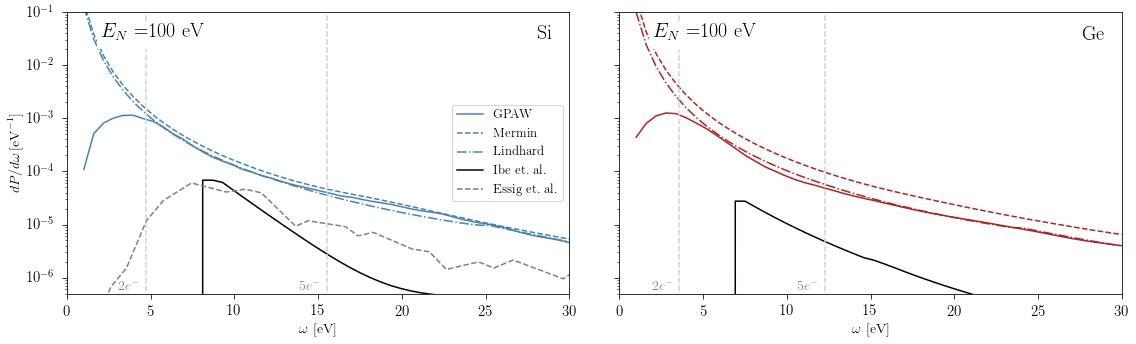

In [50]:
Si_2e_threshold=Si_gpaw.E_gap+Si_gpaw.e0
Ge_2e_threshold=Ge_gpaw.E_gap+Ge_gpaw.e0

Si_5e_threshold=Si_gpaw.E_gap+4.0*Si_gpaw.e0
Ge_5e_threshold=Ge_gpaw.E_gap+4.0*Ge_gpaw.e0

fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=True)

axs[0].plot(omlist,dPdomega_Si_gpaw,label="GPAW",color="Steelblue")
axs[0].plot(omlist,dPdomega_Si_mermin,"--",label="Mermin",color="Steelblue")
axs[0].plot(omlist,dPdomega_Si_lindhard,"-.",label="Lindhard",color="Steelblue")
axs[0].plot(omlist,dPdomega_Si_ibe,"-",label="Ibe et.~al.",color="Black")
axs[0].plot(essigx,essig_P,"--",label="Essig et.~al.",color="Gray")

axs[0].plot([Si_2e_threshold,Si_2e_threshold],[1e-7,1e0],"--",color="lightgray")
axs[0].plot([Si_5e_threshold,Si_5e_threshold],[1e-7,1e0],"--",color="lightgray")

axs[0].text(Si_2e_threshold-0.4,0.6e-6,"$2e^-$",fontsize=14,color="gray",horizontalalignment="right")
axs[0].text(Si_5e_threshold-0.4,0.6e-6,"$5e^-$",fontsize=14,color="gray",horizontalalignment="right")
axs[0].text(29,3e-2,"Si",fontsize=20,horizontalalignment="right")
axs[0].text(2,3e-2,"$E_N=$"+str(int(Entest))+" eV",fontsize=20,backgroundcolor="white",horizontalalignment="left")

axs[0].set_yscale("Log")
axs[0].set_xlim([0,30])
axs[0].set_ylim([5e-7,1e-1])
axs[0].set_xlabel("$\omega$ [eV]")
axs[0].set_ylabel("$dP/d\omega\, [\mathrm{eV}^{-1}]$")
axs[0].legend(fontsize=13,loc="center right")

axs[1].plot(omlist,dPdomega_Ge_gpaw,label="GPAW",color="Firebrick")
axs[1].plot(omlist,dPdomega_Ge_mermin,"--",label="Mermin",color="Firebrick")
axs[1].plot(omlist,dPdomega_Ge_lindhard,"-.",label="Lindhard",color="Firebrick")
axs[1].plot(omlist,dPdomega_Ge_ibe,"-",label="Ibe et.~al.",color="Black")

axs[1].plot([Ge_2e_threshold,Ge_2e_threshold],[1e-7,1e3],"--",color="lightgray")
axs[1].plot([Ge_5e_threshold,Ge_5e_threshold],[1e-7,1e3],"--",color="lightgray")

axs[1].text(29,3e-2,"Ge",fontsize=20,horizontalalignment="right")
axs[1].text(2,3e-2,"$E_N=$"+str(int(Entest))+" eV",fontsize=20,backgroundcolor="white",horizontalalignment="left")

axs[1].text(Ge_2e_threshold-0.4,0.6e-6,"$2e^-$",fontsize=14,color="gray",horizontalalignment="right")
axs[1].text(Ge_5e_threshold-0.4,0.6e-6,"$5e^-$",fontsize=14,color="gray",horizontalalignment="right")

axs[1].set_xlim([0,30])
axs[1].set_xlabel("$\omega$ [eV]")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.1)

fig.savefig(plotdir+"darkelf_migdal_1.pdf",bbox_inches='tight')


To avoid recomputing the shake of probability for each point in phase space, darkELF tabulated the function I(omega)=1/En dP/domega when the darkELF object is initiated. The results are interpolated and stored in the function "I_tab"

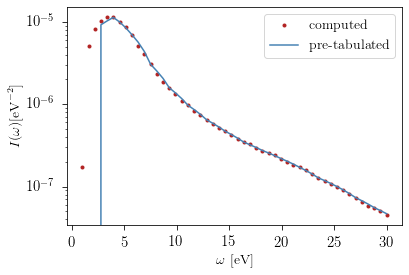

In [18]:
I_test_computed=Si_gpaw.dPdomega(omlist,1.0,method="grid")
I_test_tabulated=Si_gpaw.I_tab(omlist)

plt.plot(omlist,I_test_computed,".",color="Firebrick",label="computed")
plt.plot(omlist,I_test_tabulated,color="Steelblue",label="pre-tabulated")

plt.yscale("Log")
plt.xlabel("$\omega$ [eV]")
plt.ylabel("$I(\omega) [\mathrm{eV}^{-2}]$")

plt.legend()

The user can overwrite the default pre-tabulated function, by calling "tabulate_I". E.g. perhaps one wants to use "Lindhard" or "Ibe", rather than "grid", or impose a kcut or Nshell assumption which differs from the default

In [19]:
?Si_gpaw.tabulate_I

Signature: Si_gpaw.tabulate_I(method='grid', kcut=0, Nshell=0, Zionkdependence=True)
Docstring:
tabulates and interpolates I(omega)=1/En dP/domega and stores the result as an internal function, which can be used to speed up the rate calculations 

Inputs
------
method: ["grid","Lindhard","Ibe"]
    use interpolated grid of epsilon, Lindhard analytic epsilon or the atomic calculation by Ibe et al 1707.07258
kcut: float
    option to include a maximum k value in the integration (helpful if you
    wish to avoid to using ELF in high k regime where it may be more uncertain)
    if kcut=0 (default), the integration is cut off at the highest k-value of the grid at hand.
    Only used if method="grid" is selected.
Nshell: int
    Number of atomic shells included in the Ibe et. al. calculation. Only used if method="Ibe" is selected.
    By default, all available shells are included.
Zionkdependence:  boole
    Include the momentum dependence of Zion(k)    
Outputs
-------
None
File:      ~/Doc

for example

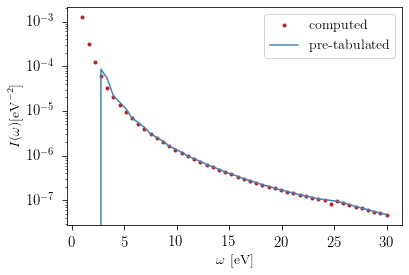

In [20]:
Si_gpaw.tabulate_I(method="Lindhard")

I_test_computed=Si_gpaw.dPdomega(omlist,1.0,method="Lindhard")
I_test_tabulated=Si_gpaw.I_tab(omlist)

plt.plot(omlist,I_test_computed,".",color="Firebrick",label="computed")
plt.plot(omlist,I_test_tabulated,color="Steelblue",label="pre-tabulated")

plt.yscale("Log")
plt.xlabel("$\omega$ [eV]")
plt.ylabel("$I(\omega) [\mathrm{eV}^{-2}]$")

plt.legend()

In the remainder over this notebook we want to use "grid", so we'll again update the pretabulated shake-off probability to be the default

In [21]:
Si_gpaw.tabulate_I(method="grid")

## Migdal differential rate

Now we are ready to compute the Migdal rate for dark matter collisions. In addition to the "method" for the shake-off probability, we can also specify how the ion is treated. Currently darkelf has the results in the free ion approximation and the impulse approximation. The latter is more accurate but substantially slower. One can set the desired approximation with the "approximation" flag.

In [22]:
?Si_gpaw.dRdomega_migdal

Signature:
Si_gpaw.dRdomega_migdal(
    omega,
    Enth=-1.0,
    sigma_n=1e-38,
    method='grid',
    approximation='free',
    kcut=0,
    Nshell=0,
    Zionkdependence=True,
    fast=False,
)
Docstring:
Returns differential rate for ionization from the Migdal effect, in 1/kg/yr/eV

Inputs
------
omega: float or array
    electron excitation energy in [eV]
sigma_n: float
    DM-nucleon reference cross section in [cm^2]
Enth: float
    lower bound on nuclear recoil energy, enables the user to exclude the soft nuclear recoil part of the phase space, where the impulse and free approximations are invalid. The default value is set to 4 times the average phonon frequency, specified by the ombar parameter in the yaml file.
method: ["grid","Lindhard","Ibe"]
    use interpolated grid of epsilon, Lindhard analytic epsilon or the atomic calculation by Ibe et al 1707.07258
approximation: ["free","impulse"] 
    use impulse approximation or free ion approximation
kcut: float
    option to includ

In [23]:
Enthreshold=0.1 # energy threshold for nuclear recoil, in eV. Needed to ensure the validity of the approximations.

Si_gpaw.update_params(mX=5e7)
Ge_gpaw.update_params(mX=5e7)

dRdomega_Si_free=Si_gpaw.dRdomega_migdal(omlist,method="grid",approximation="free",Enth=Enthreshold,sigma_n=1e-38)
dRdomega_Si_impulse=Si_gpaw.dRdomega_migdal(omlist,method="grid",approximation="impulse",Enth=Enthreshold,sigma_n=1e-38)

dRdomega_Ge_free=Ge_gpaw.dRdomega_migdal(omlist,method="grid",approximation="free",Enth=Enthreshold,sigma_n=1e-38)
dRdomega_Ge_impulse=Ge_gpaw.dRdomega_migdal(omlist,method="grid",approximation="impulse",Enth=Enthreshold,sigma_n=1e-38)


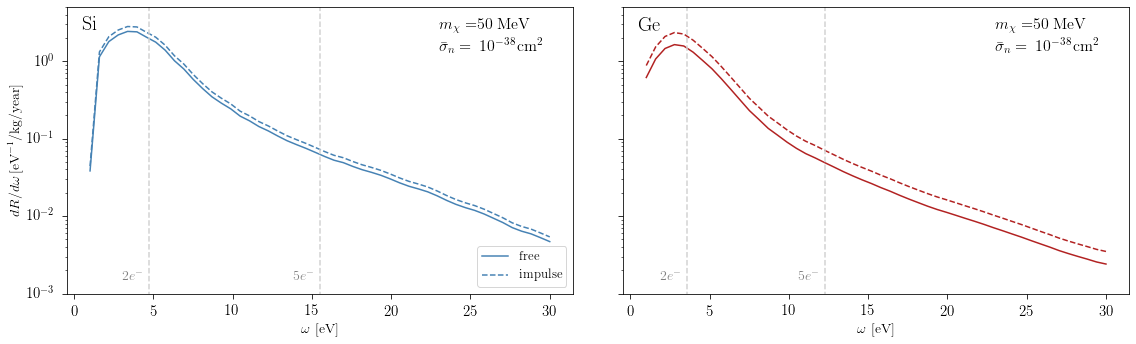

In [24]:
fig, axs = plt.subplots(1,2,figsize=(16, 5),sharey=True)


axs[0].plot(omlist,dRdomega_Si_free,label="free",color="Steelblue")
axs[0].plot(omlist,dRdomega_Si_impulse,"--",label="impulse",color="Steelblue")

axs[0].plot([Si_2e_threshold,Si_2e_threshold],[1e-6,1e3],"--",color="lightgray")
axs[0].plot([Si_5e_threshold,Si_5e_threshold],[1e-6,1e3],"--",color="lightgray")

axs[0].text(Si_2e_threshold-0.4,1.5e-3,"$2e^-$",fontsize=14,color="gray",horizontalalignment="right")
axs[0].text(Si_5e_threshold-0.4,1.5e-3,"$5e^-$",fontsize=14,color="gray",horizontalalignment="right")

axs[0].text(0.5,2.5e0,"Si",fontsize=20,horizontalalignment="left")
axs[0].text(23,2.5e0,"$m_\chi= $"+str(int(Si_gpaw.mX*1e-6))+" MeV",fontsize=16,backgroundcolor="white",horizontalalignment="left")
axs[0].text(23,1.3e0,r"$\bar \sigma_n=\, 10^{-38}\,\mathrm{cm}^2$",fontsize=16,backgroundcolor="white",horizontalalignment="left")

axs[0].set_yscale("Log")
axs[0].set_ylim([1e-3,5e0])
axs[0].set_xlabel("$\omega$ [eV]")
axs[0].set_ylabel("$dR/d\omega\, [\mathrm{eV}^{-1}$/kg/year]")
axs[0].legend(fontsize=13,loc="lower right")

axs[1].plot(omlist,dRdomega_Ge_free,label="free",color="Firebrick")
axs[1].plot(omlist,dRdomega_Ge_impulse,"--",label="impulse",color="Firebrick")

axs[1].plot([Ge_2e_threshold,Ge_2e_threshold],[1e-6,1e3],"--",color="lightgray")
axs[1].plot([Ge_5e_threshold,Ge_5e_threshold],[1e-6,1e3],"--",color="lightgray")

axs[1].text(0.5,2.5e0,"Ge",fontsize=20,horizontalalignment="left")
axs[1].text(23,2.5e0,"$m_\chi= $"+str(int(Ge_gpaw.mX*1e-6))+" MeV",fontsize=16,backgroundcolor="white",horizontalalignment="left")
axs[1].text(23,1.3e0,r"$\bar \sigma_n=\, 10^{-38}\,\mathrm{cm}^2$",fontsize=16,backgroundcolor="white",horizontalalignment="left")

axs[1].text(Ge_2e_threshold-0.4,1.5e-3,"$2e^-$",fontsize=14,color="gray",horizontalalignment="right")
axs[1].text(Ge_5e_threshold-0.4,1.5e-3,"$5e^-$",fontsize=14,color="gray",horizontalalignment="right")


axs[1].set_xlabel("$\omega$ [eV]")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.1)

fig.savefig(plotdir+"darkelf_migdal_2.pdf",bbox_inches='tight')

## Total rate

Compute the total rate subject to a particular energy threshold. The "threshold" flag refers to the energy threshold in the electrons, the "Enth" flag is the threshold on the energy of the recoiling nucleus, which must be set for theoretical consistency.

In [25]:
?Si_gpaw.R_migdal

Signature:
Si_gpaw.R_migdal(
    threshold=-1.0,
    sigma_n=1e-38,
    Enth=-1.0,
    method='grid',
    approximation='free',
    kcut=0,
    Nshell=0,
    Zionkdependence=True,
    fast=False,
)
Docstring:
Returns integrated rate for ionization from the Migdal effect, in 1/kg/yr

Inputs
------
threshold: energy threshold in [eV]. 
    Defaults to the 2e- threshold when the average number of ionization electrons is available. If this information is not available,
    the default threshold is twice the bandgap.
sigma_n: float
    DM-nucleon reference cross section in [cm^2]
Enth: float
    lower bound on nuclear recoil energy, enables the user to exclude the soft nuclear recoil part of the phase space, where the impulse and free approximations are invalid. The default value is set to 4 times the average phonon frequency, specified by the ombar parameter in the yaml file.
method: ["grid","Lindhard","Ibe"]
    use interpolated grid of epsilon, Lindhard analytic epsilon or the atomic cal

We can significantly speed up the calculation by using the pretabulated shake-off probability, using the "fast" flag. For example:

In [26]:
start=time.time()
result=Si_gpaw.R_migdal(method="grid",approximation="free",sigma_n=1e-38)
end=time.time()
print("Calculated R="+str(result)+" in "+str(end-start)+" seconds.")

start=time.time()
result=Si_gpaw.R_migdal(method="grid",approximation="free",sigma_n=1e-38,fast=True)
end=time.time()
print("Calculated R="+str(result)+" in "+str(end-start)+" seconds.")


Calculated R=5.09916188207215 in 32.23515200614929 seconds.
Calculated R=5.219925681570928 in 0.19885587692260742 seconds.


One should be aware that the impulse approximation is substantially slower than the free ion approximation, even when the "fast" flag is used.

In [27]:
start=time.time()
result=Si_gpaw.R_migdal(method="grid",approximation="impulse",sigma_n=1e-38)
end=time.time()
print("Calculated R="+str(result)+" in "+str(end-start)+" seconds.")

start=time.time()
result=Si_gpaw.R_migdal(method="grid",approximation="impulse",sigma_n=1e-38,fast=True)
end=time.time()
print("Calculated R="+str(result)+" in "+str(end-start)+" seconds.")


Calculated R=5.9459411247680025 in 229.29976201057434 seconds.
Calculated R=6.086804420947513 in 150.40413427352905 seconds.


## cross section plots

Small function to extract a "limit" for specific number of expected/observed signal events.

In [28]:
def get_limit(target,mX,threshold=-1.0,method="grid",mediator="massless",approximation="free",Enth=-1.0):
    target.update_params(mX=mX,mediator=mediator)
    R=target.R_migdal(threshold=threshold,method=method,approximation=approximation,sigma_n=1e-38,Enth=Enth,fast=True)
    if R==0.0:
        return 1.0
    else:
        return 3.0*1.0e-38/R

The impulse approximation limits took several hours to run, and are here included as a look-up table. They were obtained in the same way as the free approximation below, just switching the "approximation" flag. We also ran the impulse approximation for Enth= 4 \bar omega_phonon, Enth= 9 \bar omega_phonon and Enth=0, with \bar omega_phonon the averaged acoustic phonon frequency. (See Section IV of the paper for details.) 

In [29]:
masslist_free=np.logspace(np.log10(3.0e7),9,20)

limit_Si_free_massless=[get_limit(Si_gpaw,mX,method="grid",mediator="massless",approximation="free") for mX in masslist_free]
limit_Ge_free_massless=[get_limit(Ge_gpaw,mX,method="grid",mediator="massless",approximation="free") for mX in masslist_free]
limit_Si_free_massive=[get_limit(Si_gpaw,mX,method="grid",mediator="massive",approximation="free") for mX in masslist_free]
limit_Ge_free_massive=[get_limit(Ge_gpaw,mX,method="grid",mediator="massive",approximation="free") for mX in masslist_free]


Si_massless_impulse_4=np.loadtxt("./data/migdal_Si_massless_4.0.txt").T
Ge_massless_impulse_4=np.loadtxt("./data/migdal_Ge_massless_4.0.txt").T
Si_massive_impulse_4=np.loadtxt("./data/migdal_Si_massive_4.0.txt").T
Ge_massive_impulse_4=np.loadtxt("./data/migdal_Ge_massive_4.0.txt").T

Si_massless_impulse_9=np.loadtxt("./data/migdal_Si_massless_9.0.txt").T
Ge_massless_impulse_9=np.loadtxt("./data/migdal_Ge_massless_9.0.txt").T
Si_massive_impulse_9=np.loadtxt("./data/migdal_Si_massive_9.0.txt").T
Ge_massive_impulse_9=np.loadtxt("./data/migdal_Ge_massive_9.0.txt").T

Si_massless_impulse_0=np.loadtxt("./data/migdal_Si_massless_0.0.txt").T
Ge_massless_impulse_0=np.loadtxt("./data/migdal_Ge_massless_0.0.txt").T
Si_massive_impulse_0=np.loadtxt("./data/migdal_Si_massive_0.0.txt").T
Ge_massive_impulse_0=np.loadtxt("./data/migdal_Ge_massive_0.0.txt").T


In [30]:
Si_massless_impulse_0_interpol=interpolate.interp1d(Si_massless_impulse_0[0],Si_massless_impulse_0[1])
Ge_massless_impulse_0_interpol=interpolate.interp1d(Ge_massless_impulse_0[0],Ge_massless_impulse_0[1])
Si_massive_impulse_0_interpol=interpolate.interp1d(Si_massive_impulse_0[0],Si_massive_impulse_0[1])
Ge_massive_impulse_0_interpol=interpolate.interp1d(Ge_massive_impulse_0[0],Ge_massive_impulse_0[1])

read in the limits from 1908.10881

In [31]:
essig_existing_massless = np.array(pandas.read_csv("./data/essig_nuclear_existing_massless.txt", header=None, lineterminator='\n'))
essig_existing_massive = np.array(pandas.read_csv("./data/essig_nuclear_existing_massive.txt", header=None, lineterminator='\n'))

essig_migdal_massless = np.array(pandas.read_csv("./data/essig_Xemigdal_recast_massless.txt", header=None, lineterminator='\n'))
essig_migdal_massive = np.array(pandas.read_csv("./data/essig_Xemigdal_recast_massive.txt", header=None, lineterminator='\n'))

existing_massless_x=essig_existing_massless.T[0]
existing_massless_y=essig_existing_massless.T[1]*(Si_gpaw.alphaEM*Si_gpaw.me/(1e6*essig_existing_massless.T[0]*Si_gpaw.v0))**4 # correct for different convention

migdal_massless_x=essig_migdal_massless.T[0]
migdal_massless_y=essig_migdal_massless.T[1]*(Si_gpaw.alphaEM*Si_gpaw.me/(1e6*essig_migdal_massless.T[0]*Si_gpaw.v0))**4 # correct for different convention

existing_massive_x=essig_existing_massive.T[0]
existing_massive_y=essig_existing_massive.T[1]

migdal_massive_x=essig_migdal_massive.T[0]
migdal_massive_y=essig_migdal_massive.T[1]

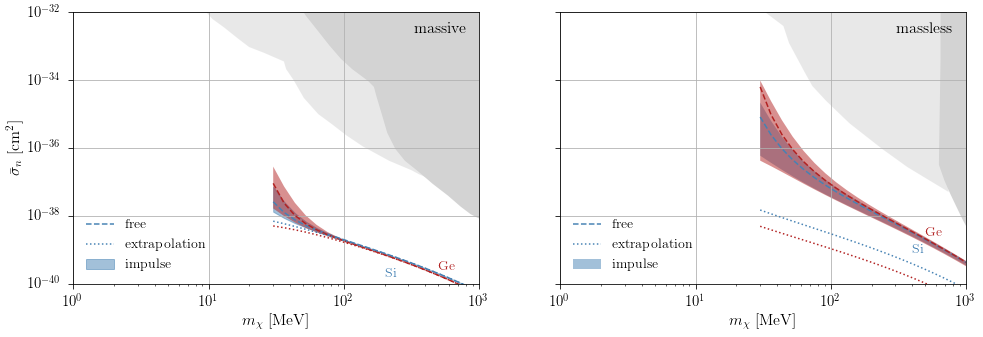

In [47]:
fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=True)
fig.subplots_adjust(wspace=0.2)

# massive

axs[0].plot(masslist_free*1e-6,limit_Si_free_massive,"--",label="free",color="Steelblue")
axs[0].plot(masslist_free*1e-6,limit_Ge_free_massive,"--",color="Firebrick")

axs[0].fill_between(Si_massive_impulse_4[0]*1e-6,Si_massive_impulse_4[1],Si_massive_impulse_9[1],color="Steelblue",alpha=0.5,label="impulse")
axs[0].fill_between(Ge_massive_impulse_4[0]*1e-6,Ge_massive_impulse_4[1],Ge_massive_impulse_9[1],facecolor="Firebrick",alpha=0.5)

axs[0].plot(masslist_free*1e-6,list(map(Si_massive_impulse_0_interpol,masslist_free)),":",label="extrapolation",color="Steelblue")
axs[0].plot(masslist_free*1e-6,list(map(Ge_massive_impulse_0_interpol,masslist_free)),":",color="Firebrick")

axs[0].fill_between(existing_massive_x,existing_massive_y,1,facecolor="darkgray",alpha=0.5)
axs[0].fill_between(migdal_massive_x,migdal_massive_y,1,facecolor="lightgray",alpha=0.5)

axs[0].set_xscale("Log")
axs[0].set_yscale("Log")
axs[0].set_xlabel("$m_\chi$ [MeV]",fontsize=16)
axs[0].set_ylabel(r"$\bar \sigma_n$ [$\mathrm{cm}^2$]",fontsize=16)
axs[0].set_xlim([1,1e3])
axs[0].set_ylim([1e-40,1e-32])
axs[0].legend(frameon=False,loc="lower left")
axs[0].grid()

axs[0].text(200,3e-40,"Si",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Steelblue")
axs[0].text(500,0.5e-39,"Ge",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Firebrick")


# massless

axs[1].plot(masslist_free*1e-6,limit_Si_free_massless,"--",label="free",color="Steelblue")
axs[1].plot(masslist_free*1e-6,limit_Ge_free_massless,"--",color="Firebrick")

axs[1].fill_between(Si_massless_impulse_4[0]*1e-6,Si_massless_impulse_4[1],Si_massless_impulse_9[1],facecolor="Steelblue",alpha=0.5,label="impulse")
axs[1].fill_between(Ge_massless_impulse_4[0]*1e-6,Ge_massless_impulse_4[1],Ge_massless_impulse_9[1],facecolor="Firebrick",alpha=0.5)

axs[1].plot(masslist_free*1e-6,list(map(Si_massless_impulse_0_interpol,masslist_free)),":",label="extrapolation",color="Steelblue")
axs[1].plot(masslist_free*1e-6,list(map(Ge_massless_impulse_0_interpol,masslist_free)),":",color="Firebrick")

axs[1].fill_between(existing_massless_x,existing_massless_y,1,facecolor="darkgray",alpha=0.5)
axs[1].fill_between(migdal_massless_x,migdal_massless_y,1,facecolor="lightgray",alpha=0.5)

axs[1].set_xscale("Log")
axs[1].set_yscale("Log")
axs[1].set_xlabel("$m_\chi$ [MeV]",fontsize=16)
axs[1].set_xlim([1,1e3])
axs[1].legend(frameon=False,loc="lower left")
axs[1].grid()

axs[1].text(400,1.5e-39,"Si",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Steelblue")
axs[1].text(500,0.5e-38,"Ge",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Firebrick")


axs[1].text(axs[0].get_xlim()[1]*.8,axs[0].get_ylim()[1]*.5,r"massless",fontsize=16,verticalalignment='top',horizontalalignment='right')
axs[0].text(axs[1].get_xlim()[1]*.8,axs[1].get_ylim()[1]*.5,r"massive",fontsize=16,verticalalignment='top',horizontalalignment='right')


fig.savefig(plotdir+"darkelf_migdal_3.pdf",bbox_inches='tight')

## cross section plots for more materials

In [33]:
targets.list_all()

	 Al2O3
	 GaN
	 Al
	 ZnS
	 GaAs
	 SiO2
	 Si
	 Ge
	 SiC
	 C
	 Xe


Use the Mermin method for all of them.

In [34]:
mX=1.0e8

Si = darkelf(target='Si',mX=mX,filename="Si_mermin.dat")
Ge = darkelf(target='Ge',mX=mX,filename="Ge_mermin.dat")
GaAs = darkelf(target='GaAs',mX=mX,filename="GaAs_mermin.dat")
GaN = darkelf(target='GaN',mX=mX,filename="GaN_mermin.dat")
Al = darkelf(target='Al',mX=mX,filename="Al_mermin.dat")
SiO2 = darkelf(target='SiO2',mX=mX,filename="SiO2_mermin.dat")
ZnS = darkelf(target='ZnS',mX=mX,filename="ZnS_mermin.dat")
Al2O3 = darkelf(target='Al2O3',mX=mX,filename="Al2O3_mermin.dat")

target_list=[Al,Al2O3,GaAs,GaN,Ge,Si,SiO2,ZnS]

 .... Loading files for Si
Loaded Si_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename 
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
 .... Loading files for Ge
Loaded Ge_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from M. Nov ́ak, L. K ̈ov ́er, S. Egri, I. Cserny, J. T ́oth, D. Varga et al., A simple statistical model for quantitative analysis of plasmon structures in xps and auger spectra of free-electron-like mate

Use free ion approximation to speed up the computation

In [35]:
masslist=np.logspace(np.log10(5e7),9,50)
lim_massless=[]
lim_massive=[]
for target in target_list:
    print(target.target)
    if target.target=="Al":
        # for Al, take 5 eV threshold
        lim_massless.append([get_limit(target,mX,threshold=5.0,method="grid",mediator="massless",approximation="free",Enth=0.1) for mX in masslist])
        lim_massive.append([get_limit(target,mX,threshold=5.0,method="grid",mediator="massive",approximation="free",Enth=0.1) for mX in masslist])
    else:
        # for the others, take the default threshold (2e- or 2 x bandgap)
        lim_massless.append([get_limit(target,mX,method="grid",mediator="massless",approximation="free") for mX in masslist])
        lim_massive.append([get_limit(target,mX,method="grid",mediator="massive",approximation="free") for mX in masslist])
    
lim_massless=np.array(lim_massless) 
lim_massive=np.array(lim_massive)

Al
Al2O3
GaAs
GaN
Ge
Si
SiO2
ZnS


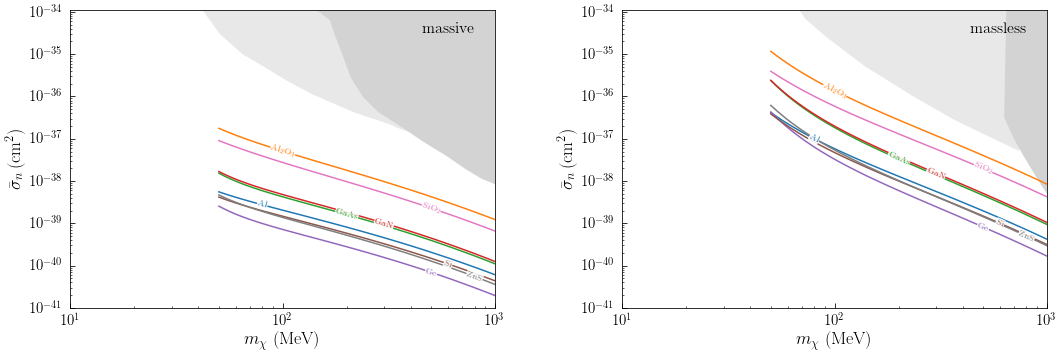

In [40]:
fig, axs = plt.subplots(1,2,figsize=(15,5.2))

targetlabels=['Al',r'Al$_2$O$_3$',"GaAs","GaN","Ge","Si",r"SiO$_2$","ZnS"]

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0.0,1.0,10))

for i in range(len(target_list)):
    axs[1].plot(masslist*1e-6,lim_massless[i],label=targetlabels[i],color=colors[i])
    axs[0].plot(masslist*1e-6,lim_massive[i],label=targetlabels[i],color=colors[i])
    
axs[0].set_xscale("Log")   
axs[0].set_yscale("Log")
axs[0].set_xlim([1e1,1e3])
axs[0].set_ylim([1e-41,1.1e-34])
axs[0].set_xlabel("$m_\chi$ (MeV)",fontsize=18)
axs[0].set_ylabel(r"$\bar\sigma_n\,(\mathrm{cm}^2)$",fontsize=18)
axs[0].tick_params(direction="in",which="both")
axs[0].fill_between(existing_massive_x,existing_massive_y,1,facecolor="darkgray",alpha=0.5)
axs[0].fill_between(migdal_massive_x,migdal_massive_y,1,facecolor="lightgray",alpha=0.5)
axs[0].text(axs[0].get_xlim()[1]*.8,axs[0].get_ylim()[1]*.5,r"massive",fontsize=16,verticalalignment='top',horizontalalignment='right')

axs[1].set_xscale("Log")   
axs[1].set_yscale("Log")  
axs[1].set_xlim([1e1,1e3])
axs[1].set_ylim([1e-41,1.1e-34])
axs[1].set_xlabel("$m_\chi$ (MeV)",fontsize=18)
axs[1].set_ylabel(r"$\bar\sigma_n\,(\mathrm{cm}^2)$",fontsize=18)
axs[1].tick_params(direction="in",which="both")
axs[1].fill_between(existing_massless_x,existing_massless_y,1,facecolor="darkgray",alpha=0.5)
axs[1].fill_between(migdal_massless_x,migdal_massless_y,1,facecolor="lightgray",alpha=0.5)
axs[1].text(axs[0].get_xlim()[1]*.8,axs[0].get_ylim()[1]*.5,r"massless",fontsize=16,verticalalignment='top',horizontalalignment='right')


fig.tight_layout()
fig.subplots_adjust(wspace = 0.3)


props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.02")
lines = axs[0].get_lines()
labelLines(lines,fontsize=9,xvals=[8e1,1e2,2e2,3e2,5e2,6e2,5e2,8e2],zorder=2.5,
           ha='center',va='center',align=True,bbox=props)

props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.02")
lines = axs[1].get_lines()
labelLines(lines,fontsize=9,xvals=[8e1,1e2,2e2,3e2,5e2,6e2,5e2,8e2],zorder=2.5,
           ha='center',va='center',align=True,bbox=props)


fig.savefig(plotdir+"darkelf_migdal_4.pdf",bbox_inches='tight')

same plots, just combined as in the paper

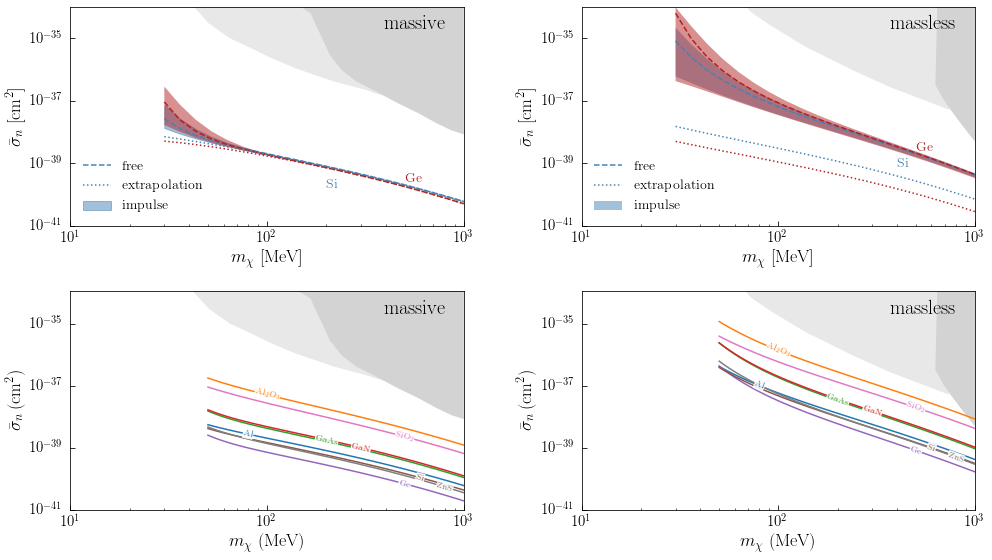

In [49]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0.0,1.0,10))

fig, axs = plt.subplots(2,2,figsize=(14,8))
fig.subplots_adjust(wspace=0.2)

# massive, Si & Ge

axs[0][0].plot(masslist_free*1e-6,limit_Si_free_massive,"--",label="free",color="Steelblue")
axs[0][0].plot(masslist_free*1e-6,limit_Ge_free_massive,"--",color="Firebrick")

axs[0][0].fill_between(Si_massive_impulse_4[0]*1e-6,Si_massive_impulse_4[1],Si_massive_impulse_9[1],color="Steelblue",alpha=0.5,label="impulse")
axs[0][0].fill_between(Ge_massive_impulse_4[0]*1e-6,Ge_massive_impulse_4[1],Ge_massive_impulse_9[1],facecolor="Firebrick",alpha=0.5)

axs[0][0].plot(masslist_free*1e-6,list(map(Si_massive_impulse_0_interpol,masslist_free)),":",label="extrapolation",color="Steelblue")
axs[0][0].plot(masslist_free*1e-6,list(map(Ge_massive_impulse_0_interpol,masslist_free)),":",color="Firebrick")

axs[0][0].fill_between(existing_massive_x,existing_massive_y,1,facecolor="darkgray",alpha=0.5)
axs[0][0].fill_between(migdal_massive_x,migdal_massive_y,1,facecolor="lightgray",alpha=0.5)

axs[0][0].set_xscale("Log")
axs[0][0].set_yscale("Log")
axs[0][0].set_xlabel("$m_\chi$ [MeV]",fontsize=18)
axs[0][0].set_ylabel(r"$\bar \sigma_n$ [$\mathrm{cm}^2$]",fontsize=18)
axs[0][0].set_xlim([1e1,1e3])
axs[0][0].set_ylim([1e-41,1e-34])
axs[0][0].legend(frameon=False,loc="lower left")
axs[0][0].tick_params(direction="in",which="both")
#axs[0][0].grid()

axs[0][0].text(200,3e-40,"Si",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Steelblue")
axs[0][0].text(500,0.5e-39,"Ge",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Firebrick")
axs[0][0].text(axs[0][0].get_xlim()[1]*.8,axs[0][0].get_ylim()[1]*.5,r"massive",fontsize=20,verticalalignment='top',horizontalalignment='right')

# massless, Si & Ge

axs[0][1].plot(masslist_free*1e-6,limit_Si_free_massless,"--",label="free",color="Steelblue")
axs[0][1].plot(masslist_free*1e-6,limit_Ge_free_massless,"--",color="Firebrick")

axs[0][1].fill_between(Si_massless_impulse_4[0]*1e-6,Si_massless_impulse_4[1],Si_massless_impulse_9[1],facecolor="Steelblue",alpha=0.5,label="impulse")
axs[0][1].fill_between(Ge_massless_impulse_4[0]*1e-6,Ge_massless_impulse_4[1],Ge_massless_impulse_9[1],facecolor="Firebrick",alpha=0.5)

axs[0][1].plot(masslist_free*1e-6,list(map(Si_massless_impulse_0_interpol,masslist_free)),":",label="extrapolation",color="Steelblue")
axs[0][1].plot(masslist_free*1e-6,list(map(Ge_massless_impulse_0_interpol,masslist_free)),":",color="Firebrick")

axs[0][1].fill_between(existing_massless_x,existing_massless_y,1,facecolor="darkgray",alpha=0.5)
axs[0][1].fill_between(migdal_massless_x,migdal_massless_y,1,facecolor="lightgray",alpha=0.5)

axs[0][1].set_xscale("Log")
axs[0][1].set_yscale("Log")
axs[0][1].set_xlabel("$m_\chi$ [MeV]",fontsize=18)
axs[0][1].set_ylabel(r"$\bar \sigma_n$ [$\mathrm{cm}^2$]",fontsize=18)
axs[0][1].set_xlim([1e1,1e3])
axs[0][1].set_ylim([1e-41,1e-34])
axs[0][1].legend(frameon=False,loc="lower left")
axs[0][1].tick_params(direction="in",which="both")
#axs[0][1].grid()

axs[0][1].text(400,1.5e-39,"Si",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Steelblue")
axs[0][1].text(500,0.5e-38,"Ge",fontsize=14,verticalalignment='top',horizontalalignment='left',color="Firebrick")
axs[0][1].text(axs[0][1].get_xlim()[1]*.8,axs[0][1].get_ylim()[1]*.5,r"massless",fontsize=20,verticalalignment='top',horizontalalignment='right')

# massive all 

for i in range(len(target_list)):
    axs[1][1].plot(masslist*1e-6,lim_massless[i],label=targetlabels[i],color=colors[i])
    axs[1][0].plot(masslist*1e-6,lim_massive[i],label=targetlabels[i],color=colors[i])

axs[1][0].fill_between(existing_massive_x,existing_massive_y,1,facecolor="darkgray",alpha=0.5)
axs[1][0].fill_between(migdal_massive_x,migdal_massive_y,1,facecolor="lightgray",alpha=0.5)

axs[1][1].fill_between(existing_massless_x,existing_massless_y,1,facecolor="darkgray",alpha=0.5)
axs[1][1].fill_between(migdal_massless_x,migdal_massless_y,1,facecolor="lightgray",alpha=0.5)


axs[1][0].set_xscale("Log")   
axs[1][0].set_yscale("Log")
axs[1][0].set_xlim([1e1,1e3])
axs[1][0].set_ylim([1e-41,1.1e-34])
axs[1][0].set_xlabel("$m_\chi$ (MeV)",fontsize=18)
axs[1][0].set_ylabel(r"$\bar\sigma_n\,(\mathrm{cm}^2)$",fontsize=18)
axs[1][0].tick_params(direction="in",which="both")
axs[1][0].text(axs[1][0].get_xlim()[1]*.8,axs[1][0].get_ylim()[1]*.5,r"massive",fontsize=20,verticalalignment='top',horizontalalignment='right')
#axs[1][0].grid()

# massless all 

axs[1][1].set_xscale("Log")   
axs[1][1].set_yscale("Log")  
axs[1][1].set_xlim([1e1,1e3])
axs[1][1].set_ylim([1e-41,1.1e-34])
axs[1][1].set_xlabel("$m_\chi$ (MeV)",fontsize=18)
axs[1][1].set_ylabel(r"$\bar\sigma_n\,(\mathrm{cm}^2)$",fontsize=18)
axs[1][1].tick_params(direction="in",which="both")
axs[1][1].text(axs[1][0].get_xlim()[1]*.8,axs[1][0].get_ylim()[1]*.5,r"massless",fontsize=20,verticalalignment='top',horizontalalignment='right')
#axs[1][1].grid()

fig.tight_layout()
fig.subplots_adjust(wspace = 0.3,hspace = 0.3)


props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.02")
lines = axs[1][0].get_lines()
labelLines(lines,fontsize=9,xvals=[8e1,1e2,2e2,3e2,5e2,6e2,5e2,8e2],zorder=2.5,
           ha='center',va='center',align=True,bbox=props)

props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.02")
lines = axs[1][1].get_lines()
labelLines(lines,fontsize=9,xvals=[8e1,1e2,2e2,3e2,5e2,6e2,5e2,8e2],zorder=2.5,
           ha='center',va='center',align=True,bbox=props)


fig.savefig(plotdir+"darkelf_migdal_5.pdf",bbox_inches='tight')